<a href="https://colab.research.google.com/github/Covpet/ENHANCING-PLANT-DISEASE-DETECTION-WITH-DEEP-LEARNING-MODELS/blob/main/plant_disease_detection_(cassava_and_maize).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Displaying images from folder: fall armyworm


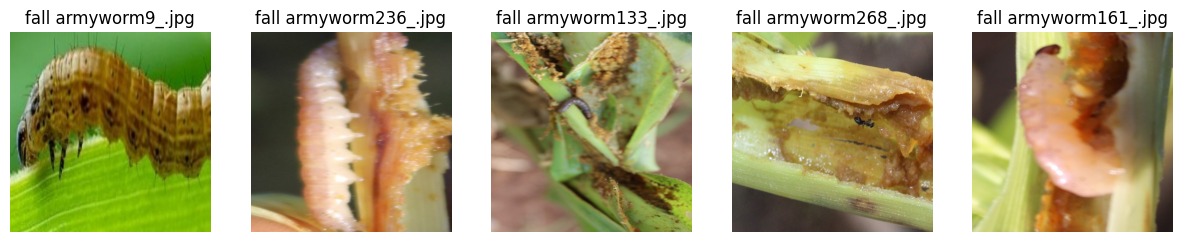

Displaying images from folder: grasshoper


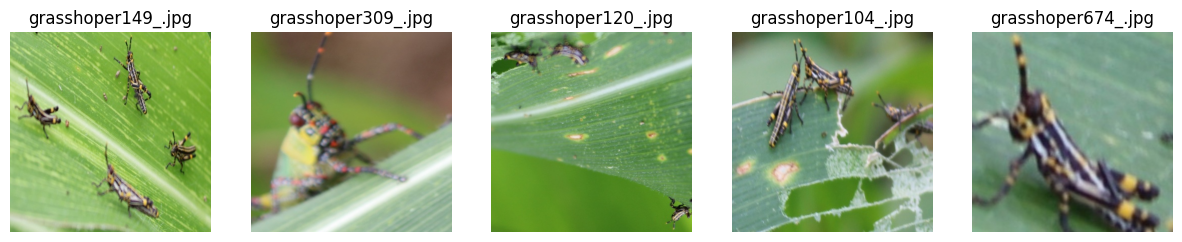

Displaying images from folder: healthy


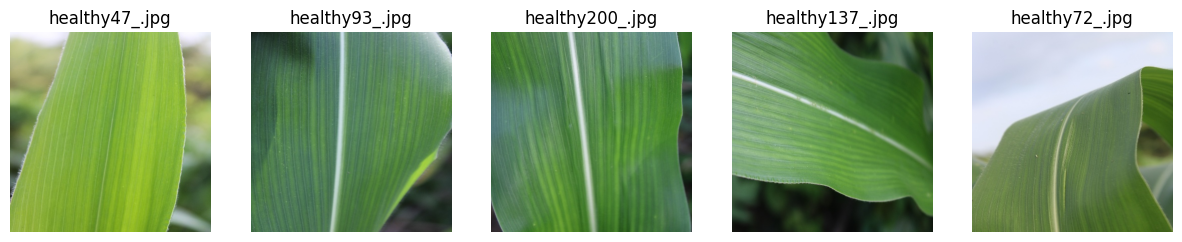

Displaying images from folder: leaf beetle


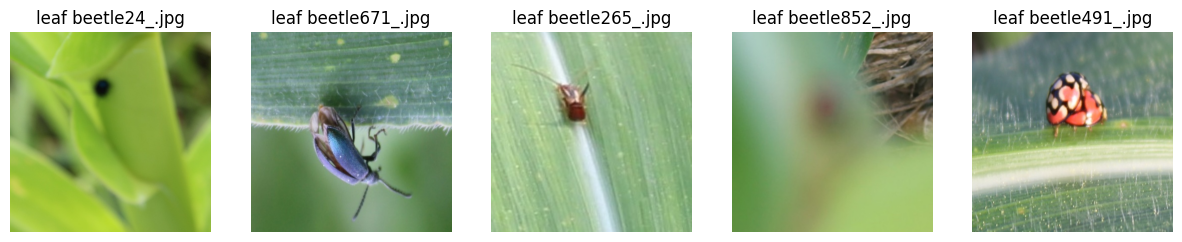

Displaying images from folder: leaf blight


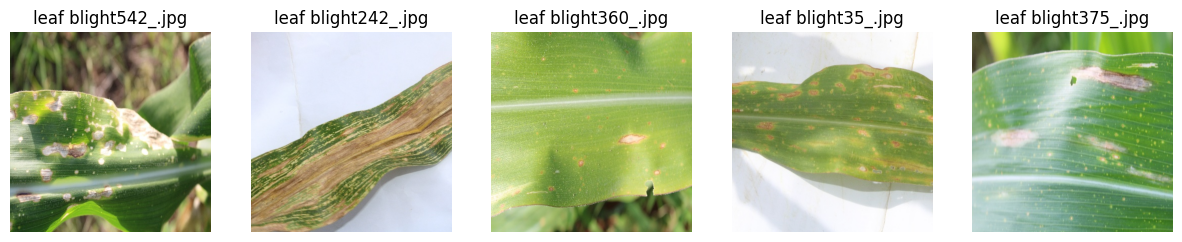

Displaying images from folder: leaf spot


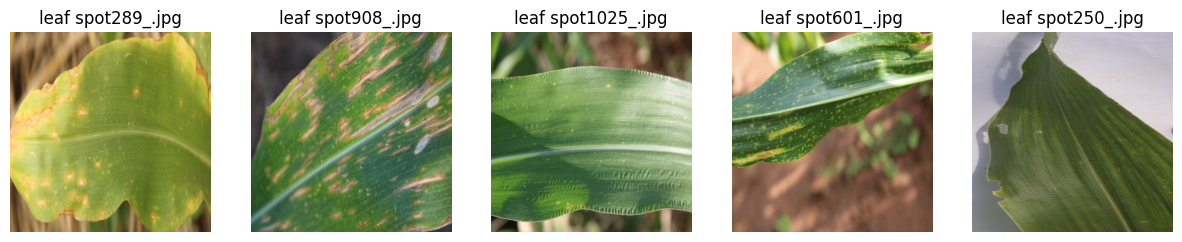

Displaying images from folder: streak virus


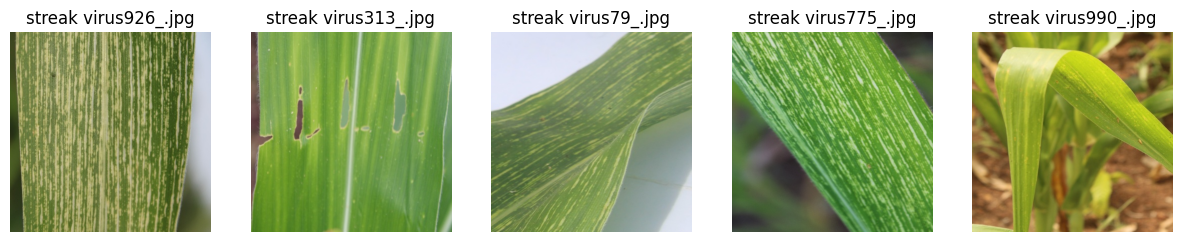

In [3]:
# Define base directory and folder names
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Function to display a sample of 5 images from each folder
def display_images_from_folders(base_dir, folders, num_images=5):
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        print(f"Displaying images from folder: {folder}")

        # Remove invalid images before displaying
        remove_invalid_images(folder_path)

        # Get all valid image files in the folder after cleanup
        files = [f for f in os.listdir(folder_path) if is_valid_image(os.path.join(folder_path, f))]

        if len(files) < num_images:
            print(f"Not enough valid images in {folder}. Found only {len(files)} valid images.")
            continue

        # Randomly select images to display
        selected_files = random.sample(files, num_images)

        # Create a subplot to display images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i, file in enumerate(selected_files):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(file)

        plt.show()

# Call the function to display images and remove invalid ones
display_images_from_folders(base_dir, folders)

                                          image_path             class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/C...  bacterial blight


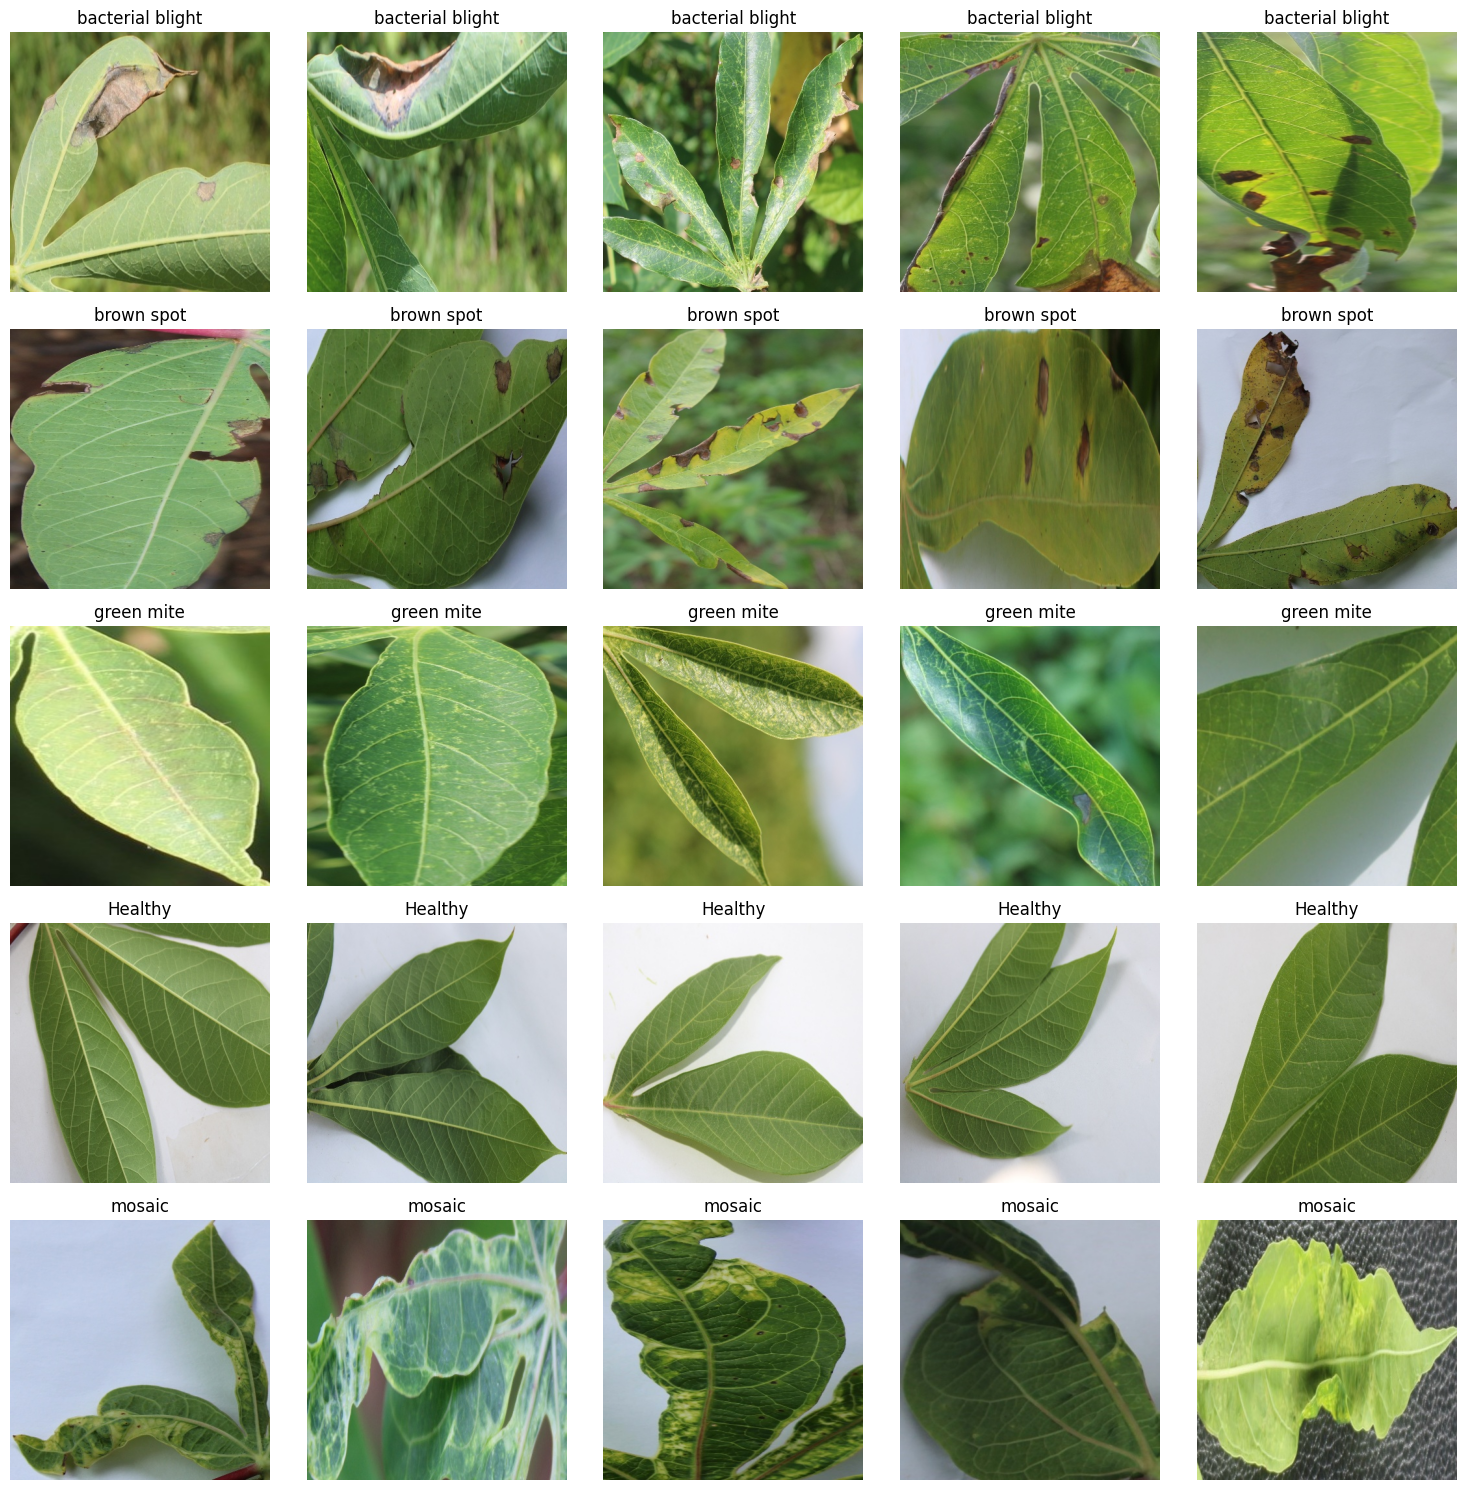

In [4]:
# Directory structure
base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# List to store image paths and their corresponding classes
image_paths = []
image_classes = []

# Iterate through each folder and collect image paths
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(folder)

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'] == folder].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [5]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

In [6]:
# Function to load and prepare the DataFrame
def load_data(base_dir, folders):
    image_paths = []
    image_classes = []

    # Iterate through each folder and collect image paths
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust if necessary for different image formats
                image_paths.append(os.path.join(folder_path, filename))
                image_classes.append(folder)

    # Create a DataFrame
    df_images = pd.DataFrame({
        'image_path': image_paths,
        'class': image_classes
    })

    return df_images

# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# Count the number of images per class
maize_class_counts = df_maize['class'].value_counts()
cassava_class_counts = df_cassava['class'].value_counts()

# Count the file formats for both datasets
maize_file_formats = df_maize['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
cassava_file_formats = df_cassava['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()

# Display counts for Maize
print("Maize Class Counts:")
print(maize_class_counts)
print("\nMaize File Format Counts:")
print(maize_file_formats)

# Display counts for Cassava
print("\nCassava Class Counts:")
print(cassava_class_counts)
print("\nCassava File Format Counts:")
print(cassava_file_formats)

Maize Class Counts:
class
leaf spot        1249
streak virus     1002
leaf blight       998
leaf beetle       938
grasshoper        683
fall armyworm     285
healthy           206
Name: count, dtype: int64

Maize File Format Counts:
image_path
jpg    5361
Name: count, dtype: int64

Cassava Class Counts:
class
bacterial blight    2772
brown spot          1506
Healthy             1283
mosaic              1235
green mite          1154
Name: count, dtype: int64

Cassava File Format Counts:
image_path
jpg    7950
Name: count, dtype: int64


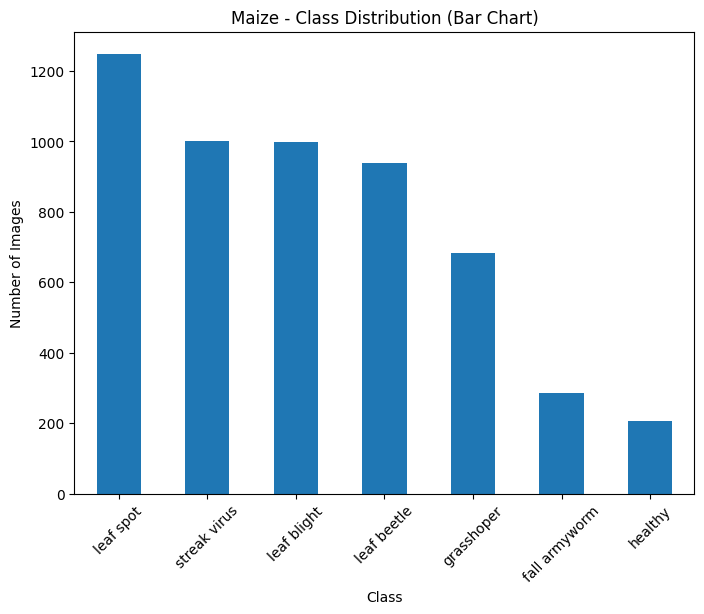

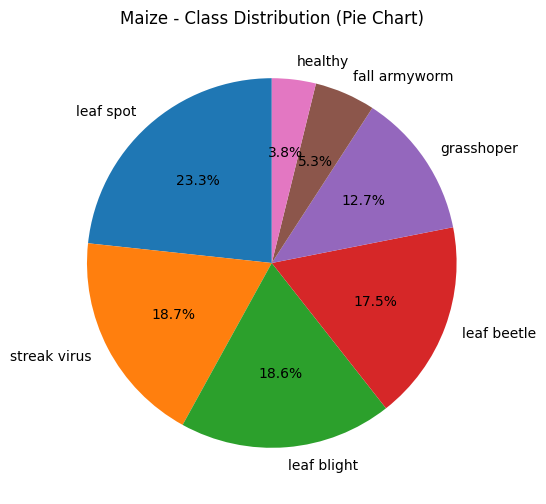

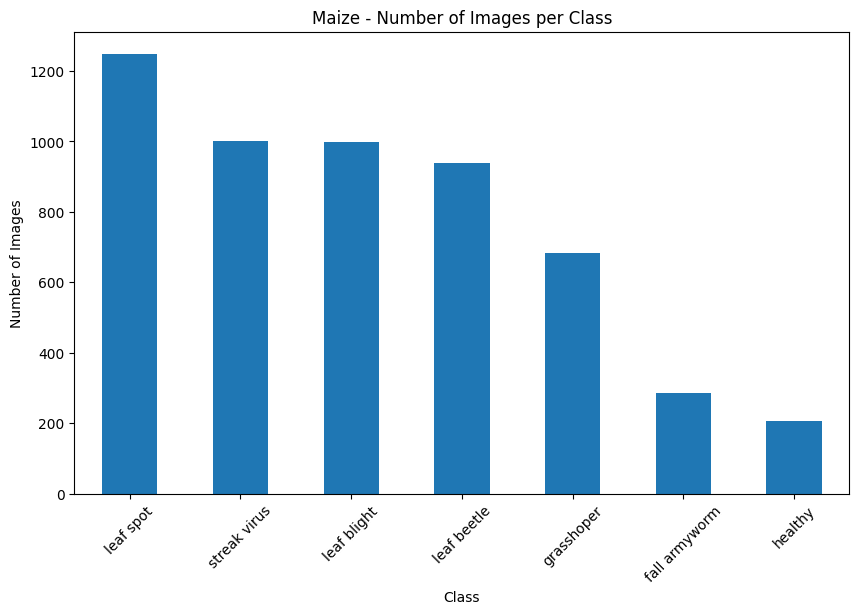

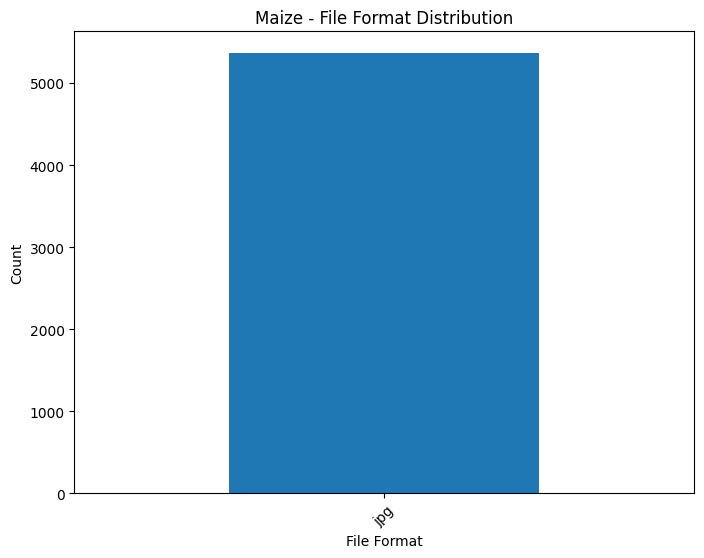

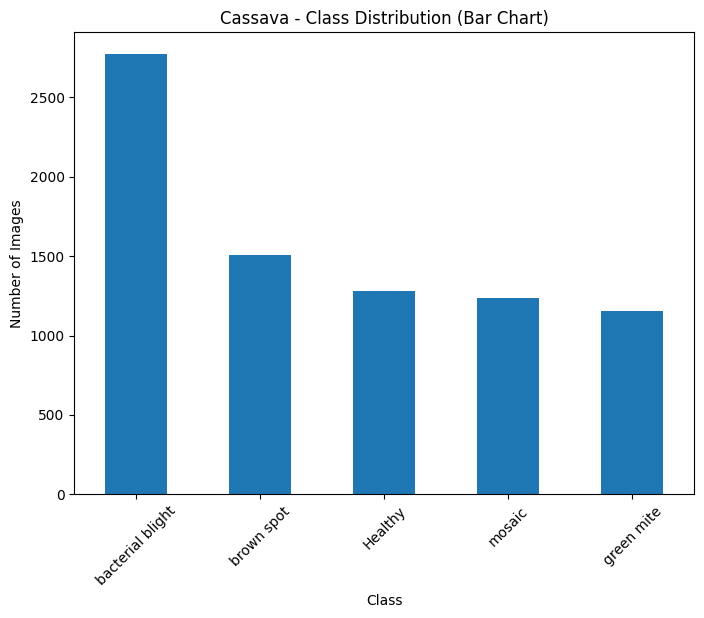

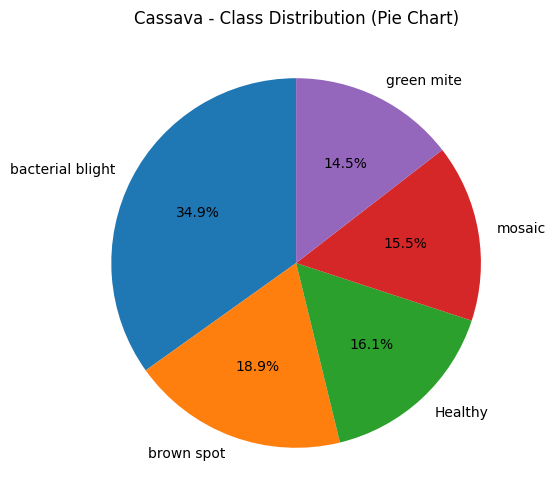

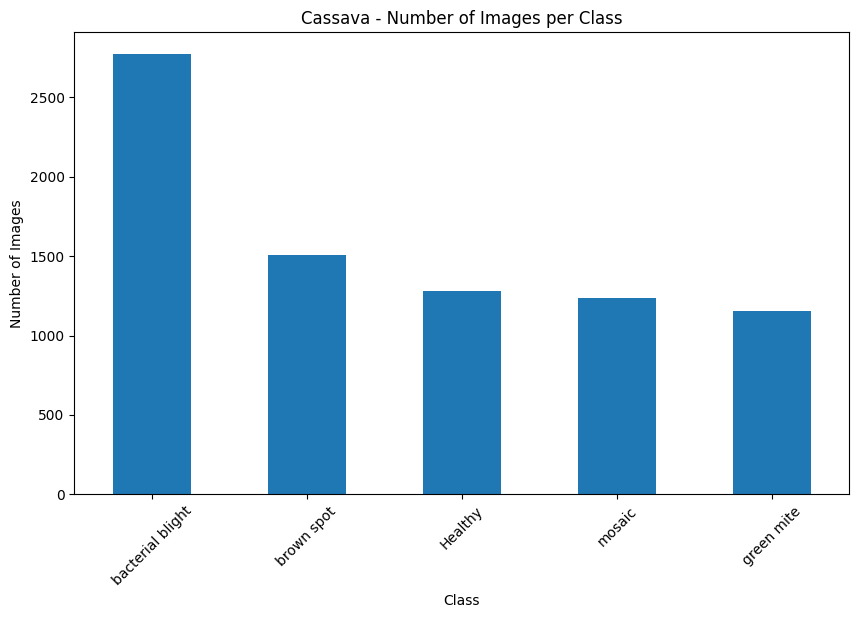

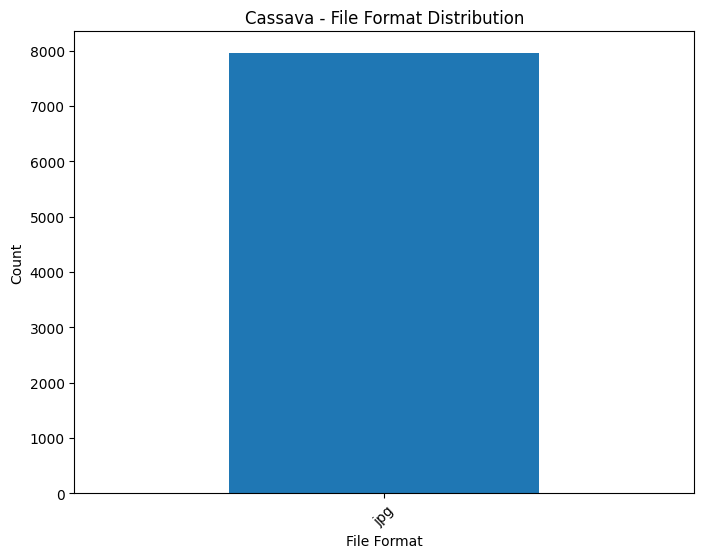

In [7]:
# For Maize
base_dir_maize = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
folders_maize = [
    'fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'
]

df_maize = load_data(base_dir_maize, folders_maize)

# For Cassava
base_dir_cassava = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'
folders_cassava = [
    'bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic'
]

df_cassava = load_data(base_dir_cassava, folders_cassava)

# EDA for Maize dataset
def plot_eda(df_images, title):
    # Class distribution (Bar Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='bar')
    plt.title(f'{title} - Class Distribution (Bar Chart)')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Class distribution (Pie Chart)
    plt.figure(figsize=(8, 6))
    df_images['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'{title} - Class Distribution (Pie Chart)')
    plt.ylabel('')
    plt.show()

    # Number of Images per Class (Bar Chart)
    class_counts = df_images['class'].value_counts()
    class_counts.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{title} - Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # File Format Distribution (Bar Chart)
    file_formats = df_images['image_path'].apply(lambda x: x.split('.')[-1]).value_counts()
    file_formats.plot(kind='bar', figsize=(8, 6))
    plt.title(f'{title} - File Format Distribution')
    plt.xlabel('File Format')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot EDA for Maize dataset
plot_eda(df_maize, 'Maize')

# Plot EDA for Cassava dataset
plot_eda(df_cassava, 'Cassava')

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

                                          image_path                class
0  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
1  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
2  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
3  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm
4  /content/drive/MyDrive/Raw Data/CCMT Dataset/M...  maize_fall armyworm


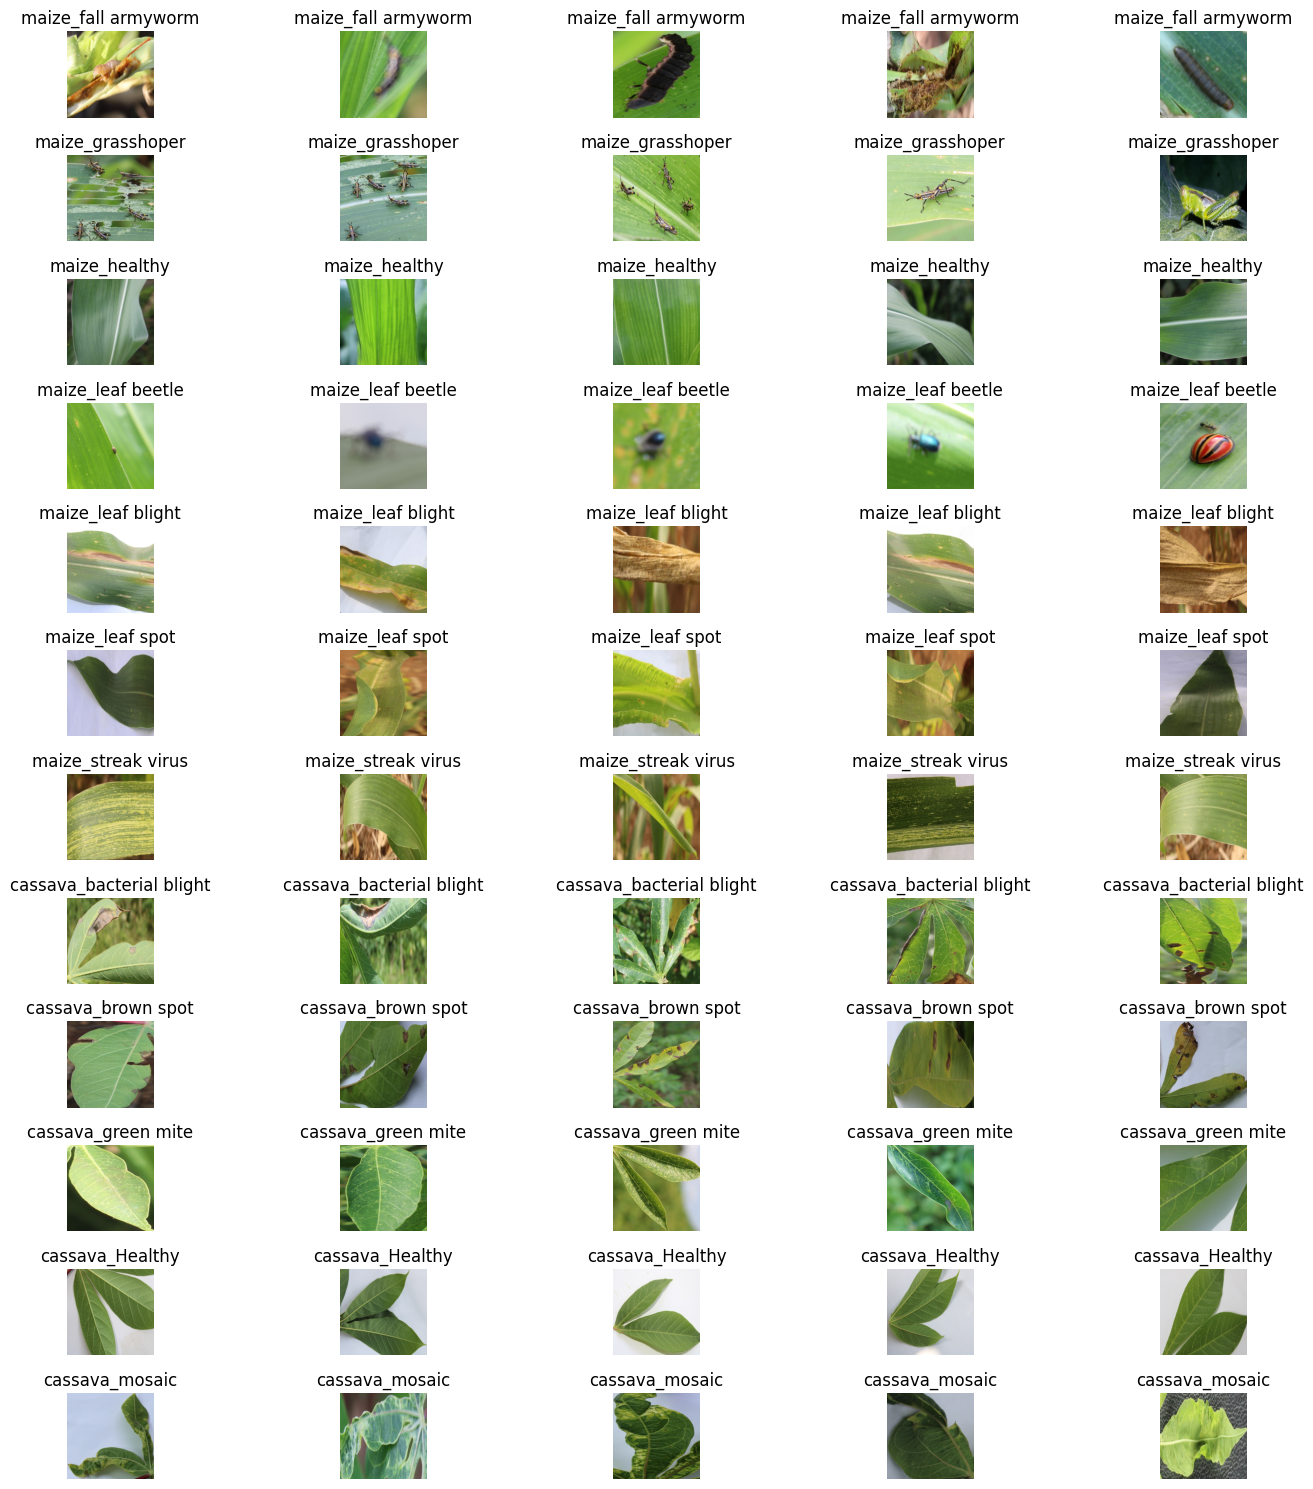

In [9]:
# Define base directories for both datasets
maize_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
cassava_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'

# Folder names for Maize dataset
maize_folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Folder names for Cassava dataset
cassava_folders = ['bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Remove invalid images before training for both datasets
for folder in maize_folders:
    remove_invalid_images(os.path.join(maize_base_dir, folder))
for folder in cassava_folders:
    remove_invalid_images(os.path.join(cassava_base_dir, folder))

# Create a DataFrame for the images in both datasets
image_paths = []
image_classes = []

# Maize dataset
for folder in maize_folders:
    folder_path = os.path.join(maize_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"maize_{folder}")

# Cassava dataset
for folder in cassava_folders:
    folder_path = os.path.join(cassava_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"cassava_{folder}")

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Show the DataFrame with image paths and their classes
print(df_images.head())

# Set up a plot to display the images
num_images_per_class = 5  # Show 5 images per class
fig, axes = plt.subplots(nrows=len(maize_folders) + len(cassava_folders), ncols=num_images_per_class, figsize=(15, 15))

# Loop through each class and display 5 images
for i, folder in enumerate(maize_folders + cassava_folders):
    # Filter images of the current class
    class_images = df_images[df_images['class'].str.contains(folder)].head(num_images_per_class)

    for j, (image_path, label) in enumerate(zip(class_images['image_path'], class_images['class'])):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(label)

plt.tight_layout()
plt.show()

In [10]:
unique_classes = df_images['class'].nunique()
print(f"Number of classes in the dataset: {unique_classes}")

Number of classes in the dataset: 12


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Define base directories for both datasets
maize_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Maize'
cassava_base_dir = '/content/drive/MyDrive/Raw Data/CCMT Dataset/Cassava'

# Folder names for Maize dataset
maize_folders = ['fall armyworm', 'grasshoper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus']

# Folder names for Cassava dataset
cassava_folders = ['bacterial blight', 'brown spot', 'green mite', 'Healthy', 'mosaic']

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the file is a valid image
        return True
    except (IOError, SyntaxError) as e:
        return False

# Function to remove invalid image files
def remove_invalid_images(folder_path):
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        if not is_valid_image(file_path):
            print(f"Removing invalid file: {file}")
            os.remove(file_path)

# Remove invalid images before training for both datasets
for folder in maize_folders:
    remove_invalid_images(os.path.join(maize_base_dir, folder))
for folder in cassava_folders:
    remove_invalid_images(os.path.join(cassava_base_dir, folder))

# Create a DataFrame for the images in both datasets
image_paths = []
image_classes = []

# Maize dataset
for folder in maize_folders:
    folder_path = os.path.join(maize_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"maize_{folder}")

# Cassava dataset
for folder in cassava_folders:
    folder_path = os.path.join(cassava_base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            image_classes.append(f"cassava_{folder}")

# Create a DataFrame
df_images = pd.DataFrame({
    'image_path': image_paths,
    'class': image_classes
})

# Set the base directories for train, validation, and test
base_dir = '/content/drive/MyDrive/dataset_split'

# Create directories for train, validation, and test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create subdirectories for each class inside train, val, test directories
for folder in maize_folders + cassava_folders:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df_images, test_size=0.2, stratify=df_images['class'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['class'], random_state=42)

# Function to copy images to corresponding directories
def copy_images(data, source_dir, target_dir):
    for _, row in data.iterrows():
        source_path = row['image_path']
        # Extract the actual class name without the prefix
        class_name = row['class'].split('_')[-1]  # Get the part after the underscore
        target_path = os.path.join(target_dir, class_name, os.path.basename(source_path))
        shutil.copy(source_path, target_path)

# Copy images to the corresponding train, validation, and test directories
copy_images(train_data, base_dir, train_dir)
copy_images(val_data, base_dir, val_dir)
copy_images(test_data, base_dir, test_dir)

# Check the directory structure to ensure images are copied correctly
for folder in maize_folders + cassava_folders:
    print(f"Train set {folder}: {len(os.listdir(os.path.join(train_dir, folder)))} images")
    print(f"Validation set {folder}: {len(os.listdir(os.path.join(val_dir, folder)))} images")
    print(f"Test set {folder}: {len(os.listdir(os.path.join(test_dir, folder)))} images")

Train set fall armyworm: 183 images
Validation set fall armyworm: 45 images
Test set fall armyworm: 57 images
Train set grasshoper: 437 images
Validation set grasshoper: 109 images
Test set grasshoper: 137 images
Train set healthy: 132 images
Validation set healthy: 33 images
Test set healthy: 41 images
Train set leaf beetle: 600 images
Validation set leaf beetle: 150 images
Test set leaf beetle: 188 images
Train set leaf blight: 638 images
Validation set leaf blight: 160 images
Test set leaf blight: 200 images
Train set leaf spot: 799 images
Validation set leaf spot: 200 images
Test set leaf spot: 250 images
Train set streak virus: 642 images
Validation set streak virus: 160 images
Test set streak virus: 200 images
Train set bacterial blight: 1774 images
Validation set bacterial blight: 444 images
Test set bacterial blight: 554 images
Train set brown spot: 964 images
Validation set brown spot: 241 images
Test set brown spot: 301 images
Train set green mite: 738 images
Validation set g